# Notes to self:
Next time start by: 

Other things: 



# General Setup

In [2]:
import os
#Specify whether to use CHEESEHEAD
os.environ['config'] = 'CHEESEHEAD'

from setup import * #Import setup module
from chad_funcs import *
import matplotlib
import math

output_folder = 'C:\\Users\\emily\\Documents\\Grad_School\\Writing\\Figures\\'


In [3]:
colorlist = ["#1F4E79", "#AD403D", "xkcd:grey", "#2E75B6","#CB6D6B","#BDD7EE", "#DB9B99", "xkcd:ocean blue", "xkcd:terracotta", "xkcd:magenta", "xkcd:blue green", "xkcd:grey", "xkcd:sky blue", "xkcd:light orange",
             "xkcd:grey blue", "xkcd:dark yellow", "xkcd:pale purple", "xkcd:coral",
              "xkcd:light olive", "xkcd:reddish brown", "xkcd:dark lavender", "xkcd:forrest green", 
             "xkcd:light cyan", "xkcd:orchid", "xkcd:puke yellow", "xkcd:periwinkle blue", "#CF7B67"]

# Functions

In [4]:
def nancounts(data, varlist, levlist):
    nancount =make_multi_df([varlist, levlist], ['var', 'lev'], dtindex) #Integer
    nanmask = make_multi_df([varlist, levlist, towlist], ['var', 'lev', 'tow'], dtindex)#Boolean

    for var in varlist: #Loop through both variable
        for lev in levlist: #Loop through all three levels
            nanmask[var, lev] = data[var][lev].notnull();
            nancount[var, lev] = 18 - data[var][lev].count(axis=1)
           
    return nanmask, nancount

# Data

In [5]:
#Read in data 
startdate = dt.datetime(2019, 6, 20)
enddate = dt.datetime(2019, 10, 13, 23, 30)
# startdate = dt.datetime(2019, 7, 1)
# enddate = dt.datetime(2019, 7, 2)
# startdate = readdate
# enddate = readdate

dtindex = readdata('dtindex', startdate, enddate) #Save dtindex as separate variable
hrz_wind = readdata('hrz_wind', startdate, enddate) #Create function to set this if I try different hrz_wind calcs #fixthis
tracdat = {'TA': readdata('TA', startdate, enddate),
              'H2O': readdata('H2O', startdate, enddate)} #data to be inerpolated
MO = readdata('MO', startdate, enddate)


In [6]:
# # def 
# var = 'H2O'
# lev = 2
# plotdate = dt.datetime(2019, 6, 20, 15)
# resolution = 200
# kernel = 'quintic'

In [7]:
#Function to remove towers without data at given timestamp
def mask_nan_tows(var, lev, nanmask, plotdate): 
    nanmask_varlev = nanmask[var][lev].loc[plotdate]

    '''Select data to use'''
    dat_nn = tracdat[var][lev].loc[tracdat[var][lev].index == plotdate].values[0, :][nanmask_varlev]

    '''Coordinates for interpolation Input'''
    ar = np.array([tc.x.values, tc.y.values]).T
    ar_nn = ar[nanmask_varlev] #coordinates of towers that have finite values
    return dat_nn, ar_nn

def plot_interp_map(ax, dat_nn, ar_nn, kern, var, lab, x_grid, y_grid, output_coords, vmin, vmax):
    #Run interpolator
    interpfunction = RBFInterpolator(ar_nn, dat_nn, kernel = kern, epsilon = 1)

    #Apply interpolated funtion to output coords
    interped_dat= interpfunction(output_coords)

    # Plot the interpolated surface
    interped_dat2D = interped_dat.reshape(x_grid.shape)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#1F4E79', '#BDD7EE', 'w', '#DB9B99', '#AD403D'])
    # cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#1F4E79', "#22985B", "#A89D22", '#AD403D'])
    if var == 'H2O':
        cmap = cmap.reversed()
    pcm = ax.pcolormesh(x_grid, y_grid, interped_dat2D, cmap=cmap, vmin = vmin, vmax = vmax)

    ax.scatter(tc.x.values, tc.y.values, c='k', marker='x', s=20) # Overlay original points
    ax.annotate(lab, (-5300, 4300))
    return pcm

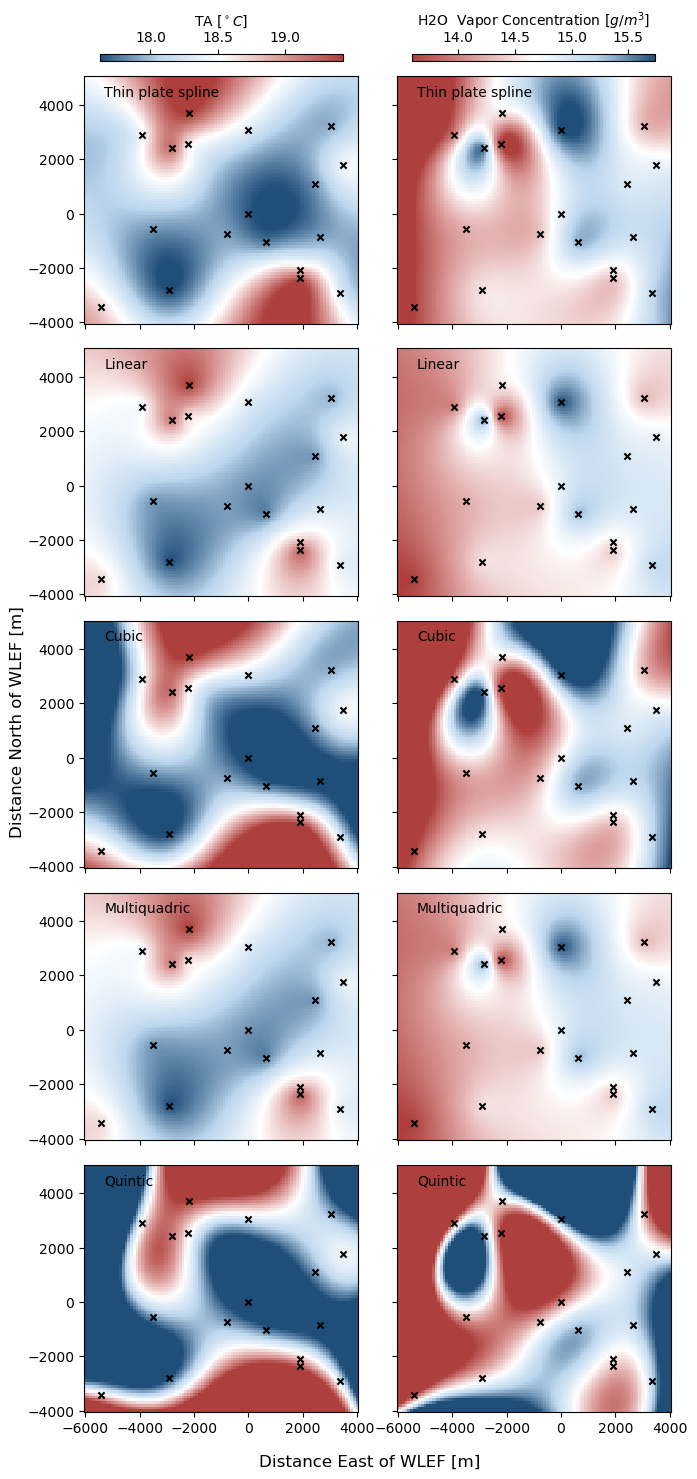

In [8]:
fig, axs = plt.subplots(5, 2, figsize = (7.5, 15), sharex= True, sharey = True)
plt.subplots_adjust(left=0.07, right=0.95, bottom=0.04, top=1.1, hspace=0.1, wspace=-.1)
kernlist = ['thin_plate_spline', 'linear', 'cubic', 'multiquadric', 'quintic']
varlist = ['TA', 'H2O']
unitlist = ['[$^\circ C$]', ' Vapor Concentration [$g/m^3$]']
lablist = ['Thin plate spline', 'Linear', 'Cubic', 'Multiquadric', 'Quintic'] #list plot labels

#Set plot params
resolution = 100
nancount_cutoff = 6
lev = 2
plotdate = dt.datetime(2019, 7, 20, 18)

#Min and max vals for pcolormesh
val_lims = {'TA': [[7, 23], [7, 23]],
            'H2O': [[13, 16], [-15, 20]]}


#Corrdinates for interpolation output
#Set range for interpolation area
x_min = round(tc.x.min() - 1000, -3)
x_max = round(tc.x.max() + 1000, -3)
y_min = round(tc.y.min() - 1000, -3)
y_max = round(tc.y.max() + 1000, -3)
#Creat grid of points to interpolate to
x_vals = np.arange(x_min, x_max + resolution, resolution)
y_vals = np.arange(y_min, y_max + resolution, resolution)
#Create output grid
x_grid, y_grid = np.meshgrid(x_vals, y_vals)
output_coords = np.vstack([x_grid.ravel(), y_grid.ravel()]).T

#Count missing data
nanmask, nancount = nancounts(tracdat, trac_varlist, trac_levlist)

for i in range(len(varlist)):
    var = varlist[i]
    unit = unitlist[i]
    nancount_varlev = nancount[var][lev][plotdate]
    dat_nn, ar_nn = mask_nan_tows(var, lev, nanmask, plotdate)
    if nancount_varlev >= nancount_cutoff:
        print('not enough data')
    else:
        for j in range(len(kernlist)):
            kern = kernlist[j]
            lab = lablist[j]
            ax = axs[j, i]
            ax.set_aspect(1)
            # pcm = plot_interp_map(ax, dat_nn, ar_nn, kern, var, lab, x_grid, y_grid, output_coords, math.floor(dat_nn.min()), math.floor(dat_nn.max()) + 1)
            pcm = plot_interp_map(ax, dat_nn, ar_nn, kern, var, lab, x_grid, y_grid, output_coords, dat_nn.min(), dat_nn.max())
    fig.colorbar(pcm, ax=axs[:, i], shrink=0.7, location = 'top', pad=0.01, aspect=40, label = var + ' ' + unit)
fig.supxlabel('Distance East of WLEF [m]', y=0.002)
fig.supylabel('Distance North of WLEF [m]', x=0.02)
plt.savefig(output_folder + 'Figure_S1.jpg', dpi=300)

Plot single tower

In [9]:
#Set parameters
resolution = 100
nancount_cutoff = 6
# kernel = 'thin_plate_spline'
# kernel = 'quintic'
kernel = kernlist[4]

plotdate = dt.datetime(2019, 7, 20, 18)
lev = 2
var = 'TA'

In [10]:
'''Count missing data'''
nanmask, nancount = nancounts(tracdat, trac_varlist, trac_levlist)
nancount_varlev = nancount[var][lev][plotdate]
nanmask_varlev = nanmask[var][lev].loc[plotdate]


'''Select data to use'''
dat_nn = tracdat[var][lev].loc[tracdat[var][lev].index == plotdate].values[0, :][nanmask_varlev]
varlist, levlist = trac_varlist, trac_levlist

'''Coordinates for interpolation Input'''
ar = np.array([tc.x.values, tc.y.values]).T
ar_nn = ar[nanmask_varlev] #coordinates of towers that have finite values

'''Corrdinates for interpolation output'''
#Set range for interpolation area
x_min = round(tc.x.min() - 1000, -3)
x_max = round(tc.x.max() + 1000, -3)
y_min = round(tc.y.min() - 1000, -3)
y_max = round(tc.y.max() + 1000, -3)

#Creat grid of points to interpolate to
x_vals = np.arange(x_min, x_max + resolution, resolution)
y_vals = np.arange(y_min, y_max + resolution, resolution)

x_grid, y_grid = np.meshgrid(x_vals, y_vals)
output_coords = np.vstack([x_grid.ravel(), y_grid.ravel()]).T




In [11]:
if nancount_varlev >= nancount_cutoff:
    print('not enough data')
    
else:
    #Run interpolator
    interpfunction = RBFInterpolator(ar_nn, dat_nn, kernel = kernel, epsilon = 1)

    #Apply interpolated funtion to output coords
    interped_dat= interpfunction(output_coords)

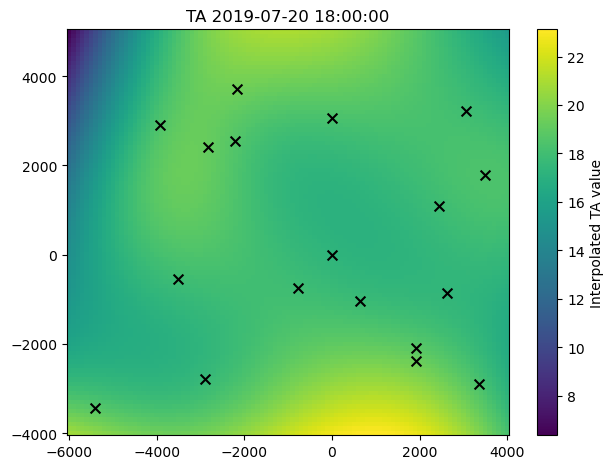

In [12]:
# Plot the interpolated surface
interped_dat2D = interped_dat.reshape(x_grid.shape)
cbar = plt.pcolormesh(x_grid, y_grid, interped_dat2D, cmap='viridis')
plt.scatter(tc.x.values, tc.y.values, c='k', marker='x', s=50) # Overlay original points
plt.title(var + ' ' + str(plotdate))

plt.colorbar(cbar, label='Interpolated ' + var + ' value')



plt.tight_layout()
plt.show()